In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

from collections import Counter
import re

In [2]:
pred = load_h5('outputs/GosaiMPRA_Borzoi_pred.h5')
pred = pred.squeeze()
pred.shape

(760679, 8, 7611)

In [3]:
targets_df = pd.read_csv('../data/Borzoi/targets_human.txt', sep='\t', index_col=0)
targets_df

,identifier,file,clip,clip_soft,scale,sum_stat,strand_pair,description
0,CNhs10608+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,1,CAGE:Clontech Human Universal Reference Total ...
1,CNhs10608-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,0,CAGE:Clontech Human Universal Reference Total ...
2,CNhs10610+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,3,CAGE:SABiosciences XpressRef Human Universal T...
3,CNhs10610-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,2,CAGE:SABiosciences XpressRef Human Universal T...
4,CNhs10612+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,5,CAGE:Universal RNA - Human Normal Tissues Bioc...
...,...,...,...,...,...,...,...,...
7606,GTEX-13FTX-1026-SM-5J2O5.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.010,sum_sqrt,7606,RNA:uterus
7607,GTEX-1MA7W-1526-SM-DHXKS.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.010,sum_sqrt,7607,RNA:uterus
7608,GTEX-11EMC-1926-SM-5A5JU.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.010,sum_sqrt,7608,RNA:vagina
7609,GTEX-12WSB-2426-SM-5EGJC.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.010,sum_sqrt,7609,RNA:vagina


In [4]:
targets_df[['assay', 'cell_type']] = targets_df['description'].str.rsplit(':', n=1, expand=True)
targets_df

,identifier,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,cell_type
0,CNhs10608+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,1,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
1,CNhs10608-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,0,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
2,CNhs10610+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,3,CAGE:SABiosciences XpressRef Human Universal T...,CAGE,SABiosciences XpressRef Human Universal Total ...
3,CNhs10610-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,2,CAGE:SABiosciences XpressRef Human Universal T...,CAGE,SABiosciences XpressRef Human Universal Total ...
4,CNhs10612+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,5,CAGE:Universal RNA - Human Normal Tissues Bioc...,CAGE,"Universal RNA - Human Normal Tissues Biochain,..."
...,...,...,...,...,...,...,...,...,...,...
7606,GTEX-13FTX-1026-SM-5J2O5.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.010,sum_sqrt,7606,RNA:uterus,RNA,uterus
7607,GTEX-1MA7W-1526-SM-DHXKS.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.010,sum_sqrt,7607,RNA:uterus,RNA,uterus
7608,GTEX-11EMC-1926-SM-5A5JU.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.010,sum_sqrt,7608,RNA:vagina,RNA,vagina
7609,GTEX-12WSB-2426-SM-5EGJC.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.010,sum_sqrt,7609,RNA:vagina,RNA,vagina


In [5]:
targets_df['assay'] = targets_df['assay'].str.replace('DNASE', 'DNase').str.replace('CHIP:', '')
targets_df['index'] = targets_df.index

In [6]:
targets_df

,identifier,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,cell_type,index
0,CNhs10608+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,1,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ...",0
1,CNhs10608-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,0,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ...",1
2,CNhs10610+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,3,CAGE:SABiosciences XpressRef Human Universal T...,CAGE,SABiosciences XpressRef Human Universal Total ...,2
3,CNhs10610-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,2,CAGE:SABiosciences XpressRef Human Universal T...,CAGE,SABiosciences XpressRef Human Universal Total ...,3
4,CNhs10612+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.000,sum,5,CAGE:Universal RNA - Human Normal Tissues Bioc...,CAGE,"Universal RNA - Human Normal Tissues Biochain,...",4
...,...,...,...,...,...,...,...,...,...,...,...
7606,GTEX-13FTX-1026-SM-5J2O5.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.010,sum_sqrt,7606,RNA:uterus,RNA,uterus,7606
7607,GTEX-1MA7W-1526-SM-DHXKS.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.010,sum_sqrt,7607,RNA:uterus,RNA,uterus,7607
7608,GTEX-11EMC-1926-SM-5A5JU.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.010,sum_sqrt,7608,RNA:vagina,RNA,vagina,7608
7609,GTEX-12WSB-2426-SM-5EGJC.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.010,sum_sqrt,7609,RNA:vagina,RNA,vagina,7609


In [7]:
df_pivot = targets_df.pivot_table(
    values="index", 
    index="cell_type", 
    columns="assay", 
    aggfunc=list,
)

df_pivot

assay,ADNP,AEBP2,AFF1,AHR,ARHGAP35,ARID1B,ARID2,ARID3A,ARID4B,ARNT,ASCL2,ASH1L,ASH2L,ATAC,ATF1,ATF2,ATF3,ATF4,ATF5,ATF7,ATM,ATOH1,BACH1,BARHL1,BARX2,BATF,BCL11A,BCL11B,BCL3,BCL6,BCL6B,BCLAF1,BCOR,BHLHE40,BMAL1,BMAL1:BMAL1_6AN_ChIPSeq / U2OS cells stably expressing Bmal1:Luc / osteosarcoma cell line U2OS stably expressing Bmal1,BMAL1:BMAL1_DMSO_ChIPSeq / U2OS cells stably expressing Bmal1:Luc / osteosarcoma cell line U2OS stably expressing Bmal1,BMI1,BRCA1,BRD4,BRD9,C11orf30,CAGE,CAGE:B lymphoblastoid cell line,CAGE:Burkitt's lymphoma cell line,CAGE:Ewing's sarcoma cell line,CAGE:Hodgkin's lymphoma cell line,CAGE:Krukenberg tumor cell line,CAGE:NK T cell leukemia cell line,CAGE:Wilms' tumor cell line,CAGE:acantholytic squamous carcinoma cell line,CAGE:acute lymphoblastic leukemia (B-ALL) cell line,CAGE:acute lymphoblastic leukemia (T-ALL) cell line,CAGE:acute myeloid leukemia (FAB M0) cell line,CAGE:acute myeloid leukemia (FAB M1) cell line,CAGE:acute myeloid leukemia (FAB M2) cell line,CAGE:acute myeloid leukemia (FAB M3) cell line,CAGE:acute myeloid leukemia (FAB M4) cell line,CAGE:acute myeloid leukemia (FAB M4eo) cell line,CAGE:acute myeloid leukemia (FAB M5) cell line,CAGE:acute myeloid leukemia (FAB M6) cell line,CAGE:acute myeloid leukemia (FAB M7) cell line,CAGE:adenocarcinoma cell line,CAGE:adrenal cortex adenocarcinoma cell line,CAGE:adult T-cell leukemia cell line,CAGE:alveolar cell carcinoma cell line,CAGE:anaplastic carcinoma cell line,CAGE:anaplastic large cell lymphoma cell line,CAGE:anaplastic squamous cell carcinoma cell line,CAGE:argyrophil small cell carcinoma cell line,CAGE:astrocytoma cell line,CAGE:b cell line,CAGE:basal cell carcinoma cell line,CAGE:bile duct carcinoma cell line,CAGE:biphenotypic B myelomonocytic leukemia cell line,CAGE:bone marrow stromal cell line,CAGE:breast carcinoma cell line,CAGE:bronchial squamous cell carcinoma cell line,CAGE:bronchioalveolar carcinoma cell line,CAGE:bronchogenic carcinoma cell line,CAGE:carcinoid cell line,CAGE:carcinosarcoma cell line,CAGE:cervical cancer cell line,CAGE:cholangiocellular carcinoma cell line,CAGE:chondrosarcoma cell line,CAGE:choriocarcinoma cell line,CAGE:chronic lymphocytic leukemia (T-CLL) cell line,CAGE:chronic myeloblastic leukemia (CML) cell line,CAGE:chronic myelogenous leukemia (CML) cell line,CAGE:chronic myelogenous leukemia cell line,CAGE:clear cell carcinoma cell line,CAGE:colon carcinoma cell line,CAGE:cord blood derived cell line,CAGE:diffuse large B-cell lymphoma cell line,CAGE:ductal cell carcinoma cell line,CAGE:embryonic kidney cell line,CAGE:embryonic pancreas cell line,CAGE:endometrial carcinoma cell line,CAGE:endometrial stromal sarcoma cell line,CAGE:endometrioid adenocarcinoma cell line,CAGE:epidermoid carcinoma cell line,CAGE:epithelioid sarcoma cell line,CAGE:epitheloid carcinoma cell line,CAGE:extraskeletal myxoid chondrosarcoma cell line,CAGE:fibrosarcoma cell line,CAGE:fibrous histiocytoma cell line,CAGE:gall bladder carcinoma cell line,CAGE:gastric adenocarcinoma cell line,CAGE:gastric cancer cell line,CAGE:gastrointestinal carcinoma cell line,CAGE:giant cell carcinoma cell line,CAGE:glassy cell carcinoma cell line,CAGE:glioblastoma cell line,CAGE:glioma cell line,CAGE:granulosa cell tumor cell line,CAGE:hairy cell leukemia cell line,CAGE:hepatic mesenchymal tumor cell line,CAGE:hepatoblastoma cell line,CAGE:hepatocellular carcinoma cell line,CAGE:hepatoma cell line,CAGE:hereditary spherocytic anemia cell line,CAGE:keratoacanthoma cell line,CAGE:large cell lung carcinoma cell line,CAGE:large cell non-keratinizing squamous carcinoma cell line,CAGE:leiomyoblastoma cell line,CAGE:leiomyoma cell line,CAGE:leiomyosarcoma cell line,CAGE:lens epithelial cell line,"CAGE:leukemia, chronic megakaryoblastic cell line",CAGE:liposarcoma cell line,CAGE:lung adenocarcinoma cell line,"CAGE:lung adenocarcinoma, papillary cell line",CAGE:lymphangiectasia cell line,"CAGE:lymphoma, malignant, hairy B-cell cell line",CAGE:malignant trichi

In [9]:
assays = ['DNASE', 'CHIP:H3K4me3', 'CHIP:H3K27ac', 'CHIP:CTCF']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF']
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']

track_df = df_pivot.loc[cell_types, assays]
track_df

assay,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
cell_type,,,,,,,,
K562,"[1397, 1398, 1399, 1901]","[2199, 2708, 2881, 4930]",NaN,"[2196, 2882]",[2883],"[2197, 2707]",[2260],"[2195, 2510, 2709, 2841]"
HepG2,"[1303, 1367, 1510]","[2215, 2680, 4663]",NaN,"[2247, 2679]",[2270],[2678],[2328],[2402]
SK-N-SH,NaN,"[2935, 5833]","[2937, 4633]",[5676],"[2934, 4907]",[5844],"[2936, 4891]","[2865, 4550]"
HCT116,[1364],"[2671, 3920]","[2873, 4908]",[5368],"[2872, 3427]",[3215],[3484],"[2553, 2670, 3666]"
A549,[1323],[2600],NaN,NaN,NaN,NaN,NaN,"[2582, 2740]"


In [10]:
for assay in assays:
    indice1 = df_pivot.loc['SK-N-SH', assay]
    indice2 = df_pivot.loc['SK-N-SH treated with 6 uM all-trans-retinoic acid for 48 hours', assay]
    
    if isinstance(indice1, list) and isinstance(indice2, list):
        track_df.loc['SK-N-SH', assay] = indice1 + indice2
    elif isinstance(indice1, list) and not isinstance(indice2, list):
        track_df.loc['SK-N-SH', assay] = indice1
    elif not isinstance(indice1, list) and isinstance(indice2, list):
        track_df.loc['SK-N-SH', assay] = indice2
    else:
        track_df.loc['SK-N-SH', assay] = None

In [11]:
track_df

assay,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
cell_type,,,,,,,,
K562,"[1397, 1398, 1399, 1901]","[2199, 2708, 2881, 4930]",NaN,"[2196, 2882]",[2883],"[2197, 2707]",[2260],"[2195, 2510, 2709, 2841]"
HepG2,"[1303, 1367, 1510]","[2215, 2680, 4663]",NaN,"[2247, 2679]",[2270],[2678],[2328],[2402]
SK-N-SH,[1422],"[2935, 5833, 2732]","[2937, 4633]","[5676, 2731]","[2934, 4907]","[5844, 2730]","[2936, 4891]","[2865, 4550, 2465]"
HCT116,[1364],"[2671, 3920]","[2873, 4908]",[5368],"[2872, 3427]",[3215],[3484],"[2553, 2670, 3666]"
A549,[1323],[2600],NaN,NaN,NaN,NaN,NaN,"[2582, 2740]"


In [12]:

# for indice in df_pivot.loc['SK-N-SH treated with 6 uM all-trans-retinoic acid for 48 hours', assays]:
#     if isinstance(indice, list) and len(indice) > 0:
#         pred_feature = pred[:, :, indice].mean(2).mean(1)
#         true_label = MPRA_df['SK-N-SH']
#         r, _ = pearson(pred_feature, true_label)
#         print(indice, r)

In [13]:
# df_1 = df_pivot.loc[cell_types]
# df_1.notna().all(axis=0)
# df_1.loc[:, df_1.notna().sum(axis=0) >= 4]

In [14]:
MPRA_df = pd.read_csv('../data/GosaiMPRA/GosaiMPRA_my_processed_data_len200_norm.csv')
print(MPRA_df.shape)

(760679, 14)


In [18]:
# average every channel

# assays = ['DNASE', 'CHIP:H3K4me3', 'CHIP:H3K27ac', 'CHIP:CTCF']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF']
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']


pred_feature_matrix = np.full(shape=(len(pred), len(cell_types), len(assays)), fill_value=np.nan)

pearson_df = pd.DataFrame(index=cell_types, columns=assays, dtype=float)

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        indice = track_df.loc[cell_type, assay]
        if isinstance(indice, list) and len(indice) > 0:
            pred_feature = pred[:, :, indice].mean(2).mean(1)
            pred_feature_matrix[:, i, j] = pred_feature
            true_label = MPRA_df[cell_type]
            r, _ = pearson(pred_feature, true_label)
            pearson_df.loc[cell_type, assay] = r
            
pearson_df

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [32]:
pred_feature_matrix.shape

(760679, 5, 8)

In [34]:
save_h5('outputs/GosaiMPRA_Borzoi_feature_matrix.h5', pred_feature_matrix)

<Axes: ylabel='Count'>

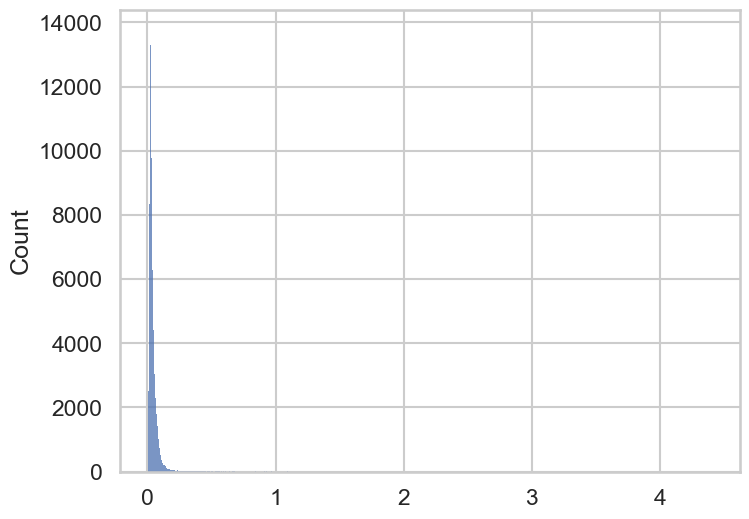

In [35]:
sns.histplot(pred_feature_matrix[:, 0, 0])

<Axes: xlabel='HepG2'>

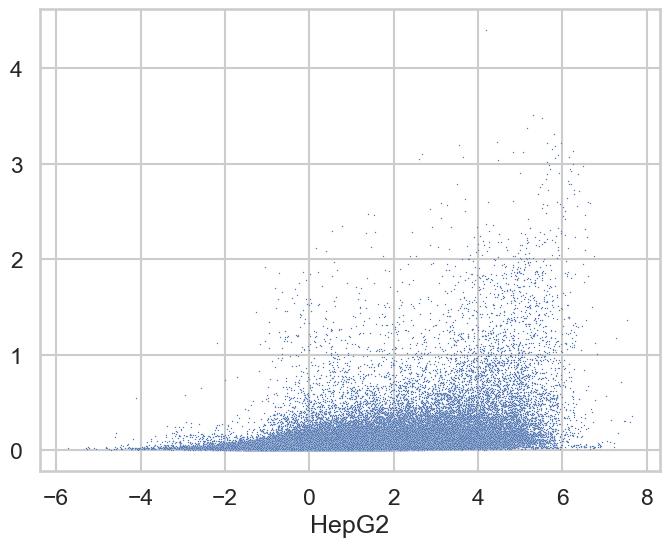

In [38]:
sns.scatterplot(x=MPRA_df['HepG2'], y=pred_feature_matrix[:, 0, 0], s=1)

In [2]:
############# Sei

sei_supp_table_1 = pd.read_excel('../data/Sei/41588_2022_1102_MOESM3_ESM.xlsx', sheet_name='Supp Table 1', skiprows=1)
sei_supp_table_1

,Chromatin Profile,AUROC,AUPRC
0,HeLa_Epithelium_Cervix | BTAF1 | ID:1,0.983,0.033
1,H9_Embryonic_Stem_Cell_Embryo | EOMES | ID:1006,0.963,0.380
2,H9_Embryonic_Stem_Cell_Embryo | EP300 | ID:1007,0.987,0.516
3,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1010,0.954,0.207
4,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1011,0.962,0.135
...,...,...,...
21902,WERI-Rb-1 | CTCF | ENCODE,0.997,0.665
21903,WERI-Rb-1 | DNase | ENCODE,0.968,0.386
21904,WI-38 | CTCF | ENCODE,0.997,0.686
21905,WI-38 (4OHTAM_20nM_72hr) | DNase | ENCODE,0.963,0.385


In [3]:
sei_supp_table_1[['cell_name', 'assay', 'source', 'part']] = (
    sei_supp_table_1['Chromatin Profile']
    .str.split(r"\s*\|\s*", n=3, expand=True)
)
sei_supp_table_1['index'] = sei_supp_table_1.index
sei_supp_table_1

,Chromatin Profile,AUROC,AUPRC,cell_name,assay,source,part,index
0,HeLa_Epithelium_Cervix | BTAF1 | ID:1,0.983,0.033,HeLa_Epithelium_Cervix,BTAF1,ID:1,None,0
1,H9_Embryonic_Stem_Cell_Embryo | EOMES | ID:1006,0.963,0.380,H9_Embryonic_Stem_Cell_Embryo,EOMES,ID:1006,None,1
2,H9_Embryonic_Stem_Cell_Embryo | EP300 | ID:1007,0.987,0.516,H9_Embryonic_Stem_Cell_Embryo,EP300,ID:1007,None,2
3,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1010,0.954,0.207,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1010,None,3
4,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1011,0.962,0.135,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1011,None,4
...,...,...,...,...,...,...,...,...
21902,WERI-Rb-1 | CTCF | ENCODE,0.997,0.665,WERI-Rb-1,CTCF,ENCODE,None,21902
21903,WERI-Rb-1 | DNase | ENCODE,0.968,0.386,WERI-Rb-1,DNase,ENCODE,None,21903
21904,WI-38 | CTCF | ENCODE,0.997,0.686,WI-38,CTCF,ENCODE,None,21904
21905,WI-38 (4OHTAM_20nM_72hr) | DNase | ENCODE,0.963,0.385,WI-38 (4OHTAM_20nM_72hr),DNase,ENCODE,None,21905


In [4]:
sei_supp_table_2 = pd.read_excel('../data/Sei/41588_2022_1102_MOESM3_ESM.xlsx', sheet_name='Supp Table 2', skiprows=1)
sei_supp_table_2

,Original Cell Type Name,Standardized Celltype Name
0,1015c,1015c
1,10326,10326
2,1184_Stem_cell,1184_Stem_cell
3,133_Astrocyte,133_Astrocyte
4,143B_Osteosarcoma_cell,143B_Osteosarcoma_cell
...,...,...
1691,ZR-75-1_Breast,ZR-75-1
1692,ZR-75-1_Embryonic_Stem_Cell_Breast,ZR-75-1
1693,ZR-75-1_Epithelium_Mammary_Gland,ZR-75-1
1694,ZR-75-30,ZR-75-30_Epithelium_Mammary_Gland


In [5]:
cell_name_map_dict = sei_supp_table_2.set_index('Original Cell Type Name')['Standardized Celltype Name'].to_dict()
cell_name_map_dict

{'1015c': '1015c',
 '10326': '10326',
 '1184_Stem_cell': '1184_Stem_cell',
 '133_Astrocyte': '133_Astrocyte',
 '143B_Osteosarcoma_cell': '143B_Osteosarcoma_cell',
 '21NT_Epithelium_Breast': '21NT_Epithelium_Breast',
 '226LDM': '226LDM',
 '22RV1_Epithelium_Prostate': '22RV1',
 '293FT_Embryonic_Kidney': '293FT',
 '293T': '293T',
 '293T_Embryonic_Kidney': '293T',
 '293T-Rex': '293T-Rex',
 '3565_cells': '3565_cells',
 '451Lu_Melanoma_Cell': '451Lu_Melanoma_Cell',
 '4star': '4star',
 '501-Mel_melanoma': '501-Mel',
 '501-Mel_Melanoma_Cell': '501-Mel',
 '5637_Stem_cell': '5637_Stem_cell',
 '5637_Urinary_Bladder': '5637_Urinary_Bladder',
 '6540_cells_Epithelium': '6540_cells_Epithelium',
 '697_B-ALL': '697_B-ALL',
 '7250_Fibroblast': '7250_Fibroblast',
 '76NF2V_Breast': '76NF2V_Breast',
 '786-0_Kidney': '786-0_Kidney',
 '786-O_Epithelium_Kidney': '786-O_Epithelium_Kidney',
 '8988T': '8988T',
 '8988t_Epithelium_Pancreas': '8988T',
 '9.4_Neuron_Prefrontal': '9.4_Neuron_Prefrontal',
 '90-8TL_Schw

In [6]:
sei_supp_table_1['cell_type'] = sei_supp_table_1['cell_name'].map(cell_name_map_dict)
sei_supp_table_1

,Chromatin Profile,AUROC,AUPRC,cell_name,assay,source,part,index,cell_type
0,HeLa_Epithelium_Cervix | BTAF1 | ID:1,0.983,0.033,HeLa_Epithelium_Cervix,BTAF1,ID:1,None,0,HeLa_Cervical_Carcinoma
1,H9_Embryonic_Stem_Cell_Embryo | EOMES | ID:1006,0.963,0.380,H9_Embryonic_Stem_Cell_Embryo,EOMES,ID:1006,None,1,H9_Embryonic_Stem_Cell_Embryo
2,H9_Embryonic_Stem_Cell_Embryo | EP300 | ID:1007,0.987,0.516,H9_Embryonic_Stem_Cell_Embryo,EP300,ID:1007,None,2,H9_Embryonic_Stem_Cell_Embryo
3,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1010,0.954,0.207,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1010,None,3,H9_Embryonic_Stem_Cell_Embryo
4,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1011,0.962,0.135,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1011,None,4,H9_Embryonic_Stem_Cell_Embryo
...,...,...,...,...,...,...,...,...,...
21902,WERI-Rb-1 | CTCF | ENCODE,0.997,0.665,WERI-Rb-1,CTCF,ENCODE,None,21902,WERI-Rb-1_Eye
21903,WERI-Rb-1 | DNase | ENCODE,0.968,0.386,WERI-Rb-1,DNase,ENCODE,None,21903,WERI-Rb-1_Eye
21904,WI-38 | CTCF | ENCODE,0.997,0.686,WI-38,CTCF,ENCODE,None,21904,WI-38_Fibroblast_Lung
21905,WI-38 (4OHTAM_20nM_72hr) | DNase | ENCODE,0.963,0.385,WI-38 (4OHTAM_20nM_72hr),DNase,ENCODE,None,21905,NaN


In [7]:
sei_supp_table_1.to_csv('../data/Sei/Sei_tracks_info.csv', index=False)

In [8]:
df_pivot = sei_supp_table_1.pivot_table(
    values="index", 
    index="cell_type", 
    columns="assay", 
    aggfunc=list,
)

df_pivot

assay                    ADNP AEBP2 AFF1 AFF4 AGO1 AGO2  AHR AHRR AP-2alpha AP-2gamma APOBEC3B   AR ARID1A ARID2 ARID3A ARID5B ARNT ARNT2 ARNTL ARRB1 ASCL1 ASCL2 ASH1L ASH2L ASXL1 ATAC-seq ATF1 ATF2 ATF3 ATF4 ATF5 ATF7IP ATOH1 ATRX AUTS2 BACH1 BACH2 BAF155 BAF170 BAHD1 BANF1 BANP BARX1 BARX2 BATF BATF3 BCAT1 BCL11A BCL11B BCL3 BCL6 BCLAF1 BCOR BDP1 BHLHE40 BIRA BMI1 BPTF BRAF BRCA1 BRD1 BRD2    BRD3    BRD4 BRD7 BRD9 BRDU BRF1 BRF2 BRPF3 BTAF1 Bach1 Brg1 C11orf30 C17orf49 C17orf96 CAMTA2 CASP8AP2 CBFA2T2 CBFB CBX1 CBX2 CBX3 CBX4 CBX5 CBX6 CBX7 CBX8 CCDC101 CCND2 CCNT2 CD59 CD74 CDC5L CDCA2 CDK12 CDK2 CDK6 CDK7 CDK8 CDK9 CDX2 CEBPA CEBPB CEBPD CEBPG CEBPZ CENPA CENPC CENPT CHAMP1 CHAT CHD1 CHD2 CHD4 CHD5 CHD7 CHD8 CHRM2 CIITA CLOCK CNOT3 COPS2 COREST CPSF3L CREB1 CREB3 CREB3L4 CREBBP CREM CRY1 CSDE1 CSNK2A1 CTBP1 CTBP2 CTCF CTCFL CTNNB1 CUX1 CtBP2 DACOR1 DAXX DCP1A DDX20 DDX21 DDX5 DEAF1  DEK DIDO1 DLX1 DLX2 DMC1 DNMT1 DNMT3A DNMT3B    DNase DNase.all.peaks DNase.fdr0.01.hot  \
cell_type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
1015c                     NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN      NaN  NaN    NaN   NaN    NaN    NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN    NaN    NaN  NaN  NaN    NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN     NaN  [8996]  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN      NaN      NaN      NaN    NaN      NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN     NaN    NaN  NaN  NaN   NaN     NaN   NaN   NaN  NaN   NaN    NaN  NaN   NaN    NaN  NaN   NaN   NaN   NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN    NaN    NaN      NaN             NaN               NaN   
10326                     NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN      NaN  NaN    NaN   NaN    NaN    NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN    NaN    NaN  NaN  NaN    NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  [8997]     NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN      NaN      NaN      NaN    NaN      NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN     NaN    NaN  NaN  NaN   NaN     NaN   NaN   NaN  NaN   NaN    NaN  NaN   NaN    NaN  NaN   NaN   NaN   NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN    NaN    NaN      NaN             NaN               NaN   
1184_Stem_cell            NaN   

In [9]:
df_avail = df_pivot[['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']]
df_avail = df_avail[(df_avail.isna().sum(axis=1) == 0)]
df_avail

assay,DNase,H3K4me3,H3K27ac,CTCF
cell_type,,,,
A549,"[3147, 4493, 4494, 19920]","[1664, 1668, 2466, 2470, 2613, 2621, 2623, 471...","[2478, 2487, 4707, 4715, 10889, 10890, 10891, ...","[4704, 4706, 5075, 5076, 5081, 5083, 5563, 557..."
AG04450_Fibroblast_Fetal_Lung,"[4497, 19983]",[4724],[4725],"[5088, 5089, 19982]"
Astrocyte_Brain,"[3235, 4651, 4652]",[4991],[4993],[4986]
BE2-C,"[4506, 4507, 20000]","[4730, 9964, 18290]","[9233, 9238, 10592, 10593, 10632]","[5098, 5099, 19999]"
BJ_Fibroblast_Foreskin,"[4508, 4509, 7138, 10659, 10660, 10684, 10685,...","[4733, 14000, 14003, 14005, 14279]","[7961, 10582, 17690]","[5100, 5101, 20001]"
B_Lymphocyte_Blood,"[635, 3146, 4516, 4517]","[919, 4740, 4742, 7037]","[2052, 4281, 4282, 4741, 7637, 7638]",[4737]
Brain,"[10678, 10679, 10680, 16416]","[2324, 2325, 2327, 2443, 9384, 9388, 9391, 939...","[2205, 9371, 9372, 9373, 9374, 9375, 9376, 937...","[5104, 5519]"
Caco-2_Epithelium_Colon,"[4514, 4515, 16625, 20080]",[4735],[17327],"[5102, 5103, 20079]"
Embryonic_Stem_Cell_Embryo,[3016],"[1705, 2210, 4098, 4102, 4106, 6849, 6850, 6983]","[2204, 2212, 4099, 4103, 4107, 9947, 9948, 995...","[9949, 9950, 9957, 9958]"


In [10]:
print(len(df_avail))

61


In [11]:
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
cell_types_standard_names = ['K562_Leukemia_Cell', 'HepG2_Hepatocellular_Carcinoma', 'SK-N-SH_Neuroblastoma_cell_Brain', 'HCT-116_Colorectal_cancer_cell_line', 'A549', 'SK-N-SH_RA_Neuron_Brain']

In [12]:
df_Sei_Siraj = df_pivot.loc[cell_types_standard_names][assays]
df_Sei_Siraj.map(lambda x: len(x) if isinstance(x, list) else 0)

assay,DNase,H3K4me3,H3K27ac,CTCF
cell_type,,,,
K562_Leukemia_Cell,58,91,51,29
HepG2_Hepatocellular_Carcinoma,9,8,9,17
SK-N-SH_Neuroblastoma_cell_Brain,0,3,3,2
HCT-116_Colorectal_cancer_cell_line,6,45,49,14
A549,4,45,53,10
SK-N-SH_RA_Neuron_Brain,4,1,0,5


In [13]:
# # pred_array = np.load('../pretrained_models/Sei/Sei_Siraj_pred_562654.npy')
# pred_array = np.load('../predict_epi_features/outputs/GosaiMPRA_Sei_pred.npy')
# print(pred_array.shape)


pred_array = load_h5('outputs/GosaiMPRA_Sei_pred_800.h5')
print(pred_array.shape)

(665600, 21907)


In [19]:
(pred_array > 1).sum()

0

In [14]:
# MPRA_df = pd.read_csv('../data/SirajMPRA/SirajMPRA_562654.csv')
MPRA_df = pd.read_csv('../data/GosaiMPRA/GosaiMPRA_my_processed_data_len200_norm.csv')
print(MPRA_df.shape)


MPRA_df = MPRA_df[:665600]

(760679, 14)


In [17]:
for assay in df_Sei_Siraj.columns:
    val1 = df_Sei_Siraj.loc['SK-N-SH_Neuroblastoma_cell_Brain', assay]
    val2 = df_Sei_Siraj.loc['SK-N-SH_RA_Neuron_Brain', assay]

    # 把 float NaN 替换成空列表
    val1 = val1 if isinstance(val1, list) else []
    val2 = val2 if isinstance(val2, list) else []

    df_Sei_Siraj.loc['SK-N-SH_merge', assay] = val1 + val2

df_Sei_Siraj

assay,DNase,H3K4me3,H3K27ac,CTCF
cell_type,,,,
K562_Leukemia_Cell,"[1490, 2919, 3167, 4632, 4633, 10715, 10716, 1...","[342, 343, 1357, 1392, 2010, 2082, 2085, 2086,...","[1346, 1352, 4928, 8948, 8957, 9199, 9462, 946...","[1364, 1388, 3511, 3512, 3513, 3514, 3515, 492..."
HepG2_Hepatocellular_Carcinoma,"[984, 990, 998, 2921, 3013, 4574, 4575, 20977,...","[1525, 1526, 1739, 1780, 4841, 4852, 9230, 20995]","[1756, 1765, 4846, 9232, 17785, 18376, 19566, ...","[144, 145, 146, 147, 1755, 1762, 4850, 5311, 5..."
SK-N-SH_Neuroblastoma_cell_Brain,NaN,"[12382, 12383, 13631]","[11641, 11642, 17960]","[5545, 13633]"
HCT-116_Colorectal_cancer_cell_line,"[3521, 3522, 3523, 3524, 4568, 4569]","[2242, 2244, 3516, 3517, 3518, 3932, 3933, 482...","[3519, 3520, 4823, 6834, 6835, 7402, 9418, 104...","[3504, 3505, 3506, 3507, 3508, 3509, 3510, 523..."
A549,"[3147, 4493, 4494, 19920]","[1664, 1668, 2466, 2470, 2613, 2621, 2623, 471...","[2478, 2487, 4707, 4715, 10889, 10890, 10891, ...","[4704, 4706, 5075, 5076, 5081, 5083, 5563, 557..."
SK-N-SH_RA_Neuron_Brain,"[2916, 4679, 4680, 21842]",[5068],NaN,"[5552, 5553, 5884, 21840, 21841]"
SK-N-SH_merge,"[2916, 4679, 4680, 21842]","[12382, 12383, 13631, 5068]","[11641, 11642, 17960]","[5545, 13633, 5552, 5553, 5884, 21840, 21841]"


In [25]:

def logit(x):
    eps = 1e-3
    x = np.clip(x, eps, 1 - eps)
    return np.log(x/(1-x))

In [26]:
# average every channel

cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
cell_names = ['K562_Leukemia_Cell', 'HepG2_Hepatocellular_Carcinoma', 'SK-N-SH_merge', 'HCT-116_Colorectal_cancer_cell_line', 'A549', ]

pred_feature_matrix = np.full(shape=(len(pred_array), len(cell_types), len(assays)), fill_value=np.nan)

pearson_df = pd.DataFrame(index=cell_types, columns=assays, dtype=float)

np.full(shape=(len(cell_types), len(assays)), fill_value=np.nan)

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        cell_name = cell_names[i]
        indice = df_Sei_Siraj.loc[cell_name, assay]
        if isinstance(indice, list) and len(indice) > 0:
            predicted_feature = logit(pred_array[:, indice]).mean(1)
            pred_feature_matrix[:, i, j] = predicted_feature
            true_label = MPRA_df[cell_type]
            r, _ = pearson(predicted_feature, true_label)
            pearson_df.loc[cell_type, assay] = r
            
pearson_df

,DNase,H3K4me3,H3K27ac,CTCF
K562,0.557,0.493,0.469,0.354
HepG2,0.508,0.447,0.444,0.294
SK-N-SH,0.487,0.520,0.581,0.315
HCT116,0.526,0.543,0.516,0.309
A549,0.320,0.278,0.366,0.218


In [45]:
# average every channel

cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
cell_names = ['K562_Leukemia_Cell', 'HepG2_Hepatocellular_Carcinoma', 'SK-N-SH_Neuroblastoma_cell_Brain', 'HCT-116_Colorectal_cancer_cell_line', 'A549', ]

pred_feature_matrix = np.full(shape=(len(pred_array), len(cell_types), len(assays)), fill_value=np.nan)

pearson_df = pd.DataFrame(index=cell_types, columns=assays, dtype=float)

np.full(shape=(len(cell_types), len(assays)), fill_value=np.nan)

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        cell_name = cell_names[i]
        if cell_type == 'SK-N-SH' and assay == 'DNase':
            # mannual select SK-N-SH_RA
            cell_name = 'SK-N-SH_RA_Neuron_Brain'

        indice = df_Sei_Siraj.loc[cell_name, assay]
        if indice is not None:
            predicted_feature = logit(pred_array[:, indice]).mean(1)
            pred_feature_matrix[:, i, j] = predicted_feature
            true_label = MPRA_df[cell_type]
            r, _ = pearson(predicted_feature, true_label)
            pearson_df.loc[cell_type, assay] = r
            
pearson_df

,DNase,H3K4me3,H3K27ac,CTCF
K562,0.535,0.483,0.464,0.400
HepG2,0.483,0.502,0.454,0.384
SK-N-SH,0.420,0.516,0.490,0.337
A549,0.347,0.363,0.361,0.251
HCT116,0.483,0.500,0.499,0.376


In [22]:
np.save('GosaiMPRA_Sei_pred_feature_matrix.npy', pred_feature_matrix)

In [7]:
###### enformer

model_info_df = pd.read_excel('../data/Enformer/41592_2021_1252_MOESM3_ESM.xlsx', sheet_name='Supplementary Table 2')
model_info_df

,index,genome,identifier,file,clip,scale,sum_stat,description,assay_type,target,assay_subtype,DNASE: cell-type agnostic,CAGE: cell-type agnostic,CAGE: IRF6,CAGE: TERT-GBM,CAGE: ZFAND3,"CAGE: HNF4A,MSMB,TERT-HEK293T,MYCrs6983267","CAGE: GP1BB,HBB,HBG1,PKLR","CAGE: F9,LDLR,SORT1",DNASE: IRF4,DNASE: IRF6,DNASE: ZFAND3,"DNASE: HNF4A,MSMB,TERT-HEK293T,MYCrs6983267","DNASE: GP1BB,HBB,HBG1,PKLR","DNASE: F9,LDLR,SORT1"
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...,DNASE,DNase/cerebellum male adult (27 years) and mal...,DNase,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...,DNASE,DNase/frontal cortex male adult (27 years) and...,DNase,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion,DNASE,DNase/chorion,DNase,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,0,ENCFF463ZLQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:Ishikawa treated with 0.02% dimethyl sul...,DNASE,DNase/Ishikawa treated with 0.02% dimethyl sul...,DNase,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4,0,ENCFF890OGQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:GM03348,DNASE,DNase/GM03348,DNase,True,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5308,5308,0,CNhs14239,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:epithelioid sarcoma cell line:HS-ES-2R,CAGE,CAGE/epithelioid sarcoma cell line:HS-ES-2R,CAGE,False,True,False,False,False,False,False,False,False,False,False,False,False,False
5309,5309,0,CNhs14240,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:squamous cell lung carcinoma cell line:RE...,CAGE,CAGE/squamous cell lung carcinoma cell line:RE...,CAGE,False,True,False,False,False,False,False,False,False,False,False,False,False,False
5310,5310,0,CNhs14241,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:gastric cancer cell line:GSS,CAGE,CAGE/gastric cancer cell line:GSS,CAGE,False,True,False,False,False,False,False,False,False,False,False,False,False,False
5311,5311,0,CNhs14244,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:carcinoid cell line:NCI-H727,CAGE,CAGE/carcinoid cell line:NCI-H727,CAGE,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [8]:
model_info_df = model_info_df[['index', 'target']].copy()
model_info_df[['assay', 'cell_type']] = model_info_df['target'].str.split('/', n=1, expand=True)
model_info_df['assay'] = model_info_df['assay'].str.replace('ChIP-Histone:', '').str.replace('ChIP-TF:', '')
model_info_df

,index,target,assay,cell_type
0,0,DNase/cerebellum male adult (27 years) and mal...,DNase,cerebellum male adult (27 years) and male adul...
1,1,DNase/frontal cortex male adult (27 years) and...,DNase,frontal cortex male adult (27 years) and male ...
2,2,DNase/chorion,DNase,chorion
3,3,DNase/Ishikawa treated with 0.02% dimethyl sul...,DNase,Ishikawa treated with 0.02% dimethyl sulfoxide...
4,4,DNase/GM03348,DNase,GM03348
...,...,...,...,...
5308,5308,CAGE/epithelioid sarcoma cell line:HS-ES-2R,CAGE,epithelioid sarcoma cell line:HS-ES-2R
5309,5309,CAGE/squamous cell lung carcinoma cell line:RE...,CAGE,squamous cell lung carcinoma cell line:RERF-LC-AI
5310,5310,CAGE/gastric cancer cell line:GSS,CAGE,gastric cancer cell line:GSS
5311,5311,CAGE/carcinoid cell line:NCI-H727,CAGE,carcinoid cell line:NCI-H727


In [9]:
df_pivot = model_info_df.pivot_table(
    values="index", 
    index="cell_type", 
    columns="assay", 
    aggfunc=list,
)
df_pivot

assay,.,3xFLAG-AHR,3xFLAG-ARID4B,3xFLAG-ATF1,3xFLAG-ATF4,3xFLAG-BCL6,3xFLAG-CEBPA,3xFLAG-CEBPG,3xFLAG-CREB1,3xFLAG-DMAP1,3xFLAG-DNMT3B,3xFLAG-DRAP1,3xFLAG-ELF3,3xFLAG-ERF,3xFLAG-ETV5,3xFLAG-FOXA3,3xFLAG-FOXP1,3xFLAG-GABPA,3xFLAG-GABPB1,3xFLAG-GATAD1,3xFLAG-GATAD2A,3xFLAG-GMEB2,3xFLAG-HBP1,3xFLAG-HHEX,3xFLAG-HLF,3xFLAG-HMG20A,3xFLAG-HMG20B,3xFLAG-HOMEZ,3xFLAG-IKZF5,3xFLAG-IRF2,3xFLAG-KAT7,3xFLAG-KAT8,3xFLAG-KDM1A,3xFLAG-KDM3A,3xFLAG-KDM6A,3xFLAG-KLF11,3xFLAG-KLF16,3xFLAG-KLF6,3xFLAG-KLF9,3xFLAG-KMT2B,3xFLAG-MBD1,3xFLAG-MIER2,3xFLAG-MIER3,3xFLAG-MIXL1,3xFLAG-MLX,3xFLAG-MXD3,3xFLAG-MXD4,3xFLAG-MYRF,3xFLAG-NFIA,3xFLAG-NFIL3,3xFLAG-NFKBIZ,3xFLAG-NFYC,3xFLAG-NR2F1,3xFLAG-NR2F6,3xFLAG-PAF1,3xFLAG-PBX2,3xFLAG-PHF5A,3xFLAG-PPARG,3xFLAG-RAD21,3xFLAG-RARA,3xFLAG-RBPJ,3xFLAG-RCOR2,3xFLAG-RERE,3xFLAG-RFX3,3xFLAG-RFXANK,3xFLAG-RXRB,3xFLAG-SAP130,3xFLAG-SLC30A9,3xFLAG-SMAD4,3xFLAG-SOX13,3xFLAG-SOX5,3xFLAG-SP5,3xFLAG-SSRP1,3xFLAG-TEAD1,3xFLAG-TEAD3,3xFLAG-TFE3,3xFLAG-TGIF2,3xFLAG-THAP11,3xFLAG-THRB,3xFLAG-ZBED5,3xFLAG-ZBTB25,3xFLAG-ZBTB26,3xFLAG-ZFP1,3xFLAG-ZFP64,3xFLAG-ZGPAT,3xFLAG-ZKSCAN8,3xFLAG-ZNF146,3xFLAG-ZNF205,3xFLAG-ZNF3,3xFLAG-ZNF48,3xFLAG-ZNF511,3xFLAG-ZNF580,3xFLAG-ZNF614,3xFLAG-ZNF639,3xFLAG-ZNF644,3xFLAG-ZNF652,3xFLAG-ZNF7,3xFLAG-ZNF792,3xFLAG-ZSCAN9,AFF1,AGO1,AGO2,ARHGAP35,ARID1B,ARID2,ARID3A,ARNT,ASH1L,ASH2L,ATAC,ATF2,ATF3,ATF4,ATF7,ATM,BACH1,BATF,BCL11A,BCL3,BCLAF1,BCOR,BHLHE40,BMAL1,BMI1,BRCA1,BRD4,BRD9,C11orf30,CAGE,CBFA2T2,CBFA2T3,CBFB,CBX1,CBX2,CBX3,CBX5,CBX8,CC2D1A,CCAR2,CDC5L,CEBPB,CEBPZ,CEBPb,CHAMP1,CHD1,CHD2,CHD4,CHD7,CLOCK,COPS2,CREB1,CREB3L1,CREBBP,CREM,CSDE1,CTBP1,CTBP2,CTCF,CUX1,DACH1,DDX20,DEAF1,DEK,DNMT1,DNase,DPF2,E2F1,E2F4,E2F6,E2F7,E2F8,E4F1,EBF1,EED,EGR1,EHMT2,ELF1,ELF4,ELK1,EP300,EP400,ESR1,ESRRA,ETS1,ETV4,ETV6,EWSR1,EZH2,EZH2phosphoT487,FIP1L1,FOS,FOSL1,FOSL2,FOXA1,FOXA2,FOXK2,FOXM1,FOXP1,FOXP2,FUS,GABPA,GABPB1,GATA1,GATA2,GATA3,GATA4,GATAD2A,GATAD2B,GMEB1,GR,GTF2F1,H2AFZ,H2AK5ac,H2AK9ac,H2BK120ac,H2BK12ac,H2BK15ac,H2BK20ac,H2BK5ac,H3F3A,H3K14ac,H3K18ac,H3K23ac,H3K23me2,H3K27Ac,H3K27ac,H3K27me3,H3K36me3,H3K4ac,H3K4me1,H3K4me2,H3K4me3,H3K56ac,H3K79me1,H3K79me2,H3K9ac,H3K9me1,H3K9me2,H3K9me3,H3T11ph,H4K12ac,H4K20me1,H4K5ac,H4K8ac,H4K91ac,HCFC1,HDAC1,HDAC2,HDAC3,HDAC6,HDGF,HES1,HLTF,HMBOX1,HNF1A,HNF4A,HNF4G,HNRNPH1,HNRNPK,HNRNPL,HNRNPLL,HNRNPUL1,HSF1,IKZF1,IKZF2,ILF3,IRF1,IRF2,IRF3,IRF4,IRF5,JUN,JUNB,JUND,KAT2A,KAT2B,KAT8,KDM1A,KDM4A,KDM4B,KDM5A,KDM5B,KHSRP,KLF16,KLF5,L3MBTL2,LARP7,LCORL,LEF1,MAFF,MAFK,MAX,MAZ,MBD2,MCM2,MCM3,MCM5,MCM7,MEF2A,MEF2B,MEF2C,MEIS2,MGA,MIER1,MITF,MLLT1,MNT,MTA1,MTA2,MTA3,MXI1,MYB,MYBL2,MYC,MYNN,NANOG,NBN,NCOA1,NCOA2,NCOA3,NCOA4,NCOA6,NCOR1,NEUROD1,NFATC1,NFATC3,NFE2,NFE2L2,NFIB,NFIC,NFRKB,NFXL1,NFYA,NFYB,NKRF,NONO,NR0B1,NR2C1,NR2C2,NR2F1,NR2F2,NR2F6,NR3C1,NRF1,NUFIP1,PAX5,PAX8,PBX3,PCBP1,PCBP2,PHB2,PHF20,PHF21A,PHF8,PKNOX1,PLRG1,PML,POLR2A,POLR2AphosphoS2,POLR2AphosphoS5,POLR2B,POLR2G,POU2F2,POU5F1,PPP1R10,PRDM10,PRPF4,PTBP1,PYGO2,RAD21,RAD51,RB1,RBBP5,RBFOX2,RBM14,RBM15,RBM17,RBM22,RBM25,RBM34,RBM39,RCOR1,RELB,REST,RFX1,RFX5,RLF,RNAPII,RNF2,RUNX1,RUNX3,RXRA,SAFB,SAFB2,SAP30,SETDB1,SFPQ,SIN3A,SIN3B,SIRT6,SIX4,SIX5,SKI,SKIL,SMAD1,SMAD2,SMAD5,SMARCA4,SMARCA5,SMARCB1,SMARCC2,SMARCE1,SMC3,SNIP1,SNRNP70,SOX13,SOX6,SP1,SPI1,SREBF1,SREBF2,SRF,SRSF1,SRSF3,SRSF4,SRSF7,SRSF9,STAT1,STAT2,STAT3,STAT5A,SUPT20H,SUPT5H,SUZ12,SYNCRIP,TAF1,TAF15,TAF7,TAF9B,TAL1,TARDBP,TBL1XR1,TBP,TBX21,TBX3,TCF12,TCF7,TCF7L2,TEAD4,TFAP4,THAP1,THRA,THRAP3,TOE1,TRIM22,TRIM24,TRIM25,TRIM28,TRIP13,U2AF1,U2AF2,UBTF,USF1,USF2,WHSC1,WRNIP1,XRCC3,XRCC5,YBX1,YBX3,YY1,ZBED1,ZBTB1,ZBTB11,ZBTB2,ZBTB33,ZBTB40,ZBTB5,ZBTB7A,ZBTB7B,ZBTB8A,ZC3H11A,ZC3H8,ZEB1,ZEB2,ZFP36,ZFP91,ZFX,ZHX1,ZHX2,ZKSCAN1,ZMIZ1,ZMYM3,ZNF143,ZNF184,ZNF207,ZNF217,ZNF24,ZNF263,ZNF274,ZNF280A,ZNF282,ZNF316,ZNF318,ZNF384,ZNF407,ZNF444,ZNF507,ZNF512B,ZNF574,ZNF579,ZNF592,ZNF622,ZNF639,ZNF687,ZNF8,ZNF830,ZSCAN29,ZZZ3,abcam,active,eGFP-ADNP,eGFP-AEBP2,eGFP-ATF1,eGFP-ATF2,eGFP-ATF3,eGFP-BACH1,eGFP-BCL11A,eGFP-BCL11B,eGFP-BCL6B,eGFP-CEBPB,eGFP-CEBPG,eGFP-CREB3,eGFP-CT

In [10]:
df_avail = df_pivot[['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']]
df_avail = df_avail[(df_avail.isna().sum(axis=1) == 0)]
df_avail

assay,DNase,H3K4me3,H3K27ac,CTCF
cell_type,,,,
A673,[340],[2783],[3657],[3336]
AG04450,[49],[1109],[1107],[1108]
CD14-positive monocyte female,"[41, 131]","[821, 1215]",[817],[836]
GM12878,"[12, 69]","[686, 1143, 1620]",[688],"[687, 1265]"
GM23338 male adult (53 years) originated from GM23248,[166],[3463],[3702],"[4324, 4474]"
H1-hESC,"[19, 70, 565]","[1509, 3972]","[732, 4164]","[712, 989, 1074]"
HCT116,[88],"[1173, 2467]","[1379, 3485]","[1055, 1172, 2203]"
HeLa-S3,"[25, 654]","[745, 2493]",[743],[742]
IMR-90,[405],[1719],[1452],[1322]


In [11]:
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']

track_df = df_pivot.loc[cell_types, assays]
track_df

assay,DNase,H3K4me3,H3K27ac,CTCF
cell_type,,,,
K562,"[121, 122, 123, 625]","[701, 1210, 1387, 3507]",NaN,"[697, 1012, 1211, 1347]"
HepG2,"[27, 91, 234]","[717, 1182, 3227]",NaN,[904]
SK-N-SH,NaN,"[1441, 4439]","[1443, 3194]","[1371, 3110]"
HCT116,[88],"[1173, 2467]","[1379, 3485]","[1055, 1172, 2203]"
A549,[47],[1102],NaN,"[1084, 1242]"


In [6]:
pred = load_h5('outputs/GosaiMPRA_Enformer_pred.h5')
pred.shape

(760679, 2, 5313)

In [12]:
MPRA_df = pd.read_csv('../data/GosaiMPRA/GosaiMPRA_my_processed_data_len200_norm.csv')
print(MPRA_df.shape)

(760679, 14)


In [18]:
# average every channel

assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']

pred_feature_matrix = np.full(shape=(len(pred), len(cell_types), len(assays)), fill_value=np.nan)

pearson_df = pd.DataFrame(index=cell_types, columns=assays, dtype=float)

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        indice = df_pivot.loc[cell_type, assay]
        if isinstance(indice, list) and len(indice) > 0:
            for idx in indice:
                pred_feature = pred[:, :, idx].mean(1)
                true_label = MPRA_df[cell_type]
                r, _ = pearson(pred_feature, true_label)
                print(cell_type, assay, idx, r)
            
pearson_df

K562 DNase 121 0.4816071363277534
K562 DNase 122 0.4644253456390126
K562 DNase 123 0.4131292168590919
K562 DNase 625 0.4816063723944516
K562 H3K4me3 701 0.5021894400924606
K562 H3K4me3 1210 0.4376592465589576
K562 H3K4me3 1387 0.4032735113679041
K562 H3K4me3 3507 0.3936855959824625
K562 CTCF 697 0.20051753499180994
K562 CTCF 1012 0.2907718944359341
K562 CTCF 1211 0.20491694559927867
K562 CTCF 1347 0.3171555814117574
HepG2 DNase 27 0.27880721326309493
HepG2 DNase 91 0.31399730755736893
HepG2 DNase 234 0.2954469807537239
HepG2 H3K4me3 717 0.40260261905845723
HepG2 H3K4me3 1182 0.3148607856280888
HepG2 H3K4me3 3227 0.2340740827940256
HepG2 CTCF 904 0.1678087544761365
SK-N-SH H3K4me3 1441 0.44859695312120584
SK-N-SH H3K4me3 4439 0.3681771060157597
SK-N-SH H3K27ac 1443 0.3477368490947369
SK-N-SH H3K27ac 3194 0.3401635739666725
SK-N-SH CTCF 1371 0.14515330308868038
SK-N-SH CTCF 3110 0.1500098912236608
HCT116 DNase 88 0.4391786955302386
HCT116 H3K4me3 1173 0.4936667190488365
HCT116 H3K4me3 24

,DNase,H3K4me3,H3K27ac,CTCF
K562,NaN,NaN,NaN,NaN
HepG2,NaN,NaN,NaN,NaN
SK-N-SH,NaN,NaN,NaN,NaN
HCT116,NaN,NaN,NaN,NaN
A549,NaN,NaN,NaN,NaN


In [19]:
# average every channel

# assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF']
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']

pred_feature_matrix = np.full(shape=(len(pred), len(cell_types), len(assays)), fill_value=np.nan)

pearson_df = pd.DataFrame(index=cell_types, columns=assays, dtype=float)

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        indice = df_pivot.loc[cell_type, assay]
        if isinstance(indice, list) and len(indice) > 0:
            pred_feature = pred[:, :, indice].mean(2).mean(1)
            pred_feature_matrix[:, i, j] = pred_feature
            true_label = MPRA_df[cell_type]
            r, _ = pearson(pred_feature, true_label)
            pearson_df.loc[cell_type, assay] = r
            
pearson_df

,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
K562,0.487,0.451,NaN,-0.003,0.454,0.122,0.106,0.244
HepG2,0.356,0.359,NaN,0.086,0.327,0.124,-0.040,0.168
SK-N-SH,NaN,0.447,0.380,0.023,0.305,-0.061,-0.003,0.152
HCT116,0.439,0.501,0.521,-0.135,0.485,-0.003,-0.102,0.172
A549,0.361,0.344,NaN,NaN,NaN,NaN,NaN,0.175


In [16]:
df_1 = df_pivot.loc[cell_types]
df_1.notna().all(axis=0)
df_1.loc[:, df_1.notna().sum(axis=0) >= 4]

assay,CTCF,DNase,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,JUND,POLR2AphosphoS5,RCOR1,REST,RFX5,SIN3A
cell_type,,,,,,,,,,,,,,,
K562,"[697, 1012, 1211, 1347]","[121, 122, 123, 625]","[698, 1388]","[699, 1209]",[1389],[700],"[701, 1210, 1387, 3507]","[702, 1386]",[762],[1348],[952],[1338],"[982, 1881]",[1349],"[962, 4288]"
HepG2,[904],"[27, 91, 234]","[749, 1181]",[1180],[772],[710],"[717, 1182, 3227]",[711],[830],"[872, 1316]",[1011],[1301],"[930, 1002]",[1309],[873]
SK-N-SH,"[1371, 3110]",NaN,[4279],[4450],"[1440, 3484]",[3899],"[1441, 4439]",[1831],"[1442, 3466]","[1056, 1370]",[1006],[1475],"[928, 1005]",[1368],[1007]
HCT116,"[1055, 1172, 2203]",[88],[3958],[1733],"[1378, 1956]",[3912],"[1173, 2467]",[1738],[2015],[1054],[976],NaN,NaN,NaN,NaN
A549,"[1084, 1242]",[47],NaN,NaN,NaN,NaN,[1102],NaN,NaN,NaN,NaN,[3354],[4195],[1637],[3044]
